## Machine Maintainence Notebook

This notebook contains the code used to develop a model for predicting machine failures over the next 24 hours.  The data is originally from a Microsoft class, and covers a fleet of 100 machines with error codes and sensor readings timestamped across a one year period.

There is an overview presentation in the Github directory for those that don't want the detailed code, however, this is commented so it should be easy enough to follow.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import gc
import psutil

import random

pd.set_option('display.max_columns', None)

basedir=os.path.abspath(os.path.dirname(__name__))+"\\"
datadir=basedir+'Data\\'
plotdir=basedir+'Plots\\'

def check_mem():
    mem=psutil.virtual_memory()
    total=mem[0]/1000000000.
    free=mem[1]/1000000000.
    print 'Memory: {:1.1f}gb tot  {:1.1f}gb free  {:2.1f}% free'.format(total,free,100*free/total)
    return

check_mem()

Memory: 8.4gb tot  4.4gb free  52.4% free


## Get Data

The data for this excercise was originally part of a Microsoft training excercise.  The next cell acquires the data from the AML github site, and saves it to the data directory.  This cell needs only to be run only once.

The next cell accesses the data on subsequent running of the program.  This is a quicker solution if there have been nochanges in the base data.

__Run this cell once.__  Initializes data files

errorfeat_df=pd.read_csv("https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Data/errorfeat.csv")
errors_df=pd.read_csv("https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Data/errors.csv")
failures_df=pd.read_csv("https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Data/failures.csv")
features_df=pd.read_csv("https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Data/features.csv")
machines_df=pd.read_csv("https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Data/machines.csv")
telemetry_df=pd.read_csv("https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Data/telemetry.csv")
telemetryfeat_df=pd.read_csv("https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Data/telemetryfeat.csv")
unlabeledfeatures_df=pd.read_csv("https://raw.githubusercontent.com/Microsoft/AMLWorkshop/master/Data/unlabeledfeatures.csv")

errorfeat_df.to_csv(datadir+'errorfeat_df'+'.csv',index=False)
errors_df.to_csv(datadir+'errors_df'+'.csv',index=False)
failures_df.to_csv(datadir+'failures_df'+'.csv',index=False)
features_df.to_csv(datadir+'features_df'+'.csv',index=False)
machines_df.to_csv(datadir+'machines_df'+'.csv',index=False)
telemetry_df.to_csv(datadir+'telemetry_df'+'.csv',index=False)
telemetryfeat_df.to_csv(datadir+'telemetryfeat_df'+'.csv',index=False)
unlabeledfeatures_df.to_csv(datadir+'unlabeledfeatures_df'+'.csv',index=False)

In [2]:
# Read previously created csv files.  Process all files available.  

errors_df=pd.read_csv(datadir+'errors_df.csv')
failures_df=pd.read_csv(datadir+'failures_df.csv')
machines_df=pd.read_csv(datadir+'machines_df.csv')
telemetry_df=pd.read_csv(datadir+'telemetry_df.csv')


datafiles=[errors_df,failures_df,machines_df,telemetry_df]
dfnames=['errors_df','failures_df','machines_df','telemetry_df']   

print 'Not all date time formats are the same. Please wait.',

telemetry_df['dt1'] =  pd.to_datetime(telemetry_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
errors_df['dt1'] =  pd.to_datetime(errors_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
failures_df['dt1'] =  pd.to_datetime(failures_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')


def split_time(df_name,df):
    
    try:
      
        df['year']=df.dt1.dt.year
        df['month']=df.dt1.dt.month
        df['day']=df.dt1.dt.day
        df['hour']=df.dt1.dt.hour
        df['dow']=df.dt1.dt.weekday_name

        df['date_str']=df.apply(lambda x: str(x.year)+'-'+\
                               str(x.month)+'-'+str(x.day),axis=1)
        df['zipper']=zip(df['machineID'],df['dt1'])
        del df['datetime'],df['year'],df['month'],df['day']
        return df
    
    
    except:
        if df_name=='machines_df':
            return df
        else:
            print df_name,'failed convert.'
            return df

for i in range(len(datafiles)):
    tmp=datafiles[i].copy()
    datafiles[i]=split_time(dfnames[i],tmp)

errors_df=datafiles[0]
failures_df=datafiles[1]
machines_df=datafiles[2]
telemetry_df=datafiles[3]
    
######## Summarize data frames

table_sum=pd.DataFrame(index=range(len(dfnames)),columns=['file_name','lines','columns','col_list'])

for i,d in enumerate(datafiles):
    
    table_sum['file_name'][i]=dfnames[i]
    table_sum['lines'][i]=len(d.index)
    table_sum['columns'][i]=len(d.columns)
    table_sum['col_list'][i]=d.columns
    
table_sum.sort_values(['lines','columns'],ascending=[False,False],inplace=True)

print '\nInitial data procesing done. Files saved.'

gc.collect()
check_mem()

table_sum.head(10)

Not all date time formats are the same. Please wait. 
Initial data procesing done. Files saved.
Memory: 8.4gb tot  4.1gb free  48.5% free


,file_name,lines,columns,col_list
3,telemetry_df,876100,10,"Index([u'machineID', u'volt', u'rotate', u'pre..."
0,errors_df,3919,7,"Index([u'machineID', u'errorID', u'dt1', u'hou..."
1,failures_df,719,6,"Index([u'machineID', u'dt1', u'hour', u'dow', ..."
2,machines_df,100,3,"Index([u'machineID', u'model', u'age'], dtype=..."


In [3]:
failures_df.head()

,machineID,dt1,hour,dow,date_str,zipper
0,1,2015-01-05 06:00:00,6,Monday,2015-1-5,"(1, 2015-01-05 06:00:00)"
1,1,2015-03-06 06:00:00,6,Friday,2015-3-6,"(1, 2015-03-06 06:00:00)"
2,1,2015-04-20 06:00:00,6,Monday,2015-4-20,"(1, 2015-04-20 06:00:00)"
3,1,2015-06-19 06:00:00,6,Friday,2015-6-19,"(1, 2015-06-19 06:00:00)"
4,1,2015-09-02 06:00:00,6,Wednesday,2015-9-2,"(1, 2015-09-02 06:00:00)"



## Data File Summary

__errors_df:__ datetime, machineID, errorID, (shows what time the error occured on a particular machine)

__failures:__ machineID, datetime, dow, hour

__machines_df:__ machineID, model(type), age

__telemetry:__ datetime, machineID, volt, rotate,pressure, vibration


### Synchronization

Before starting analysis, it is important to look at the different time stamps across the major files.  It quickly becomes apparent that the telemtry and errors data have all hourly timestamps and failure measurements are taken only at 3 and 6am.  This must be kept in mind as various lag functions are created for analysis.  This cell shows the different timestamps for the three major files.

In [4]:
print 'Failure hour timestamps:',sorted(failures_df.hour.unique())
print 'Errors hour timestamps:',sorted(errors_df.hour.unique())
print 'Telemetry hour timestamps:',sorted(telemetry_df.hour.unique())

Failure hour timestamps: [3, 6]
Errors hour timestamps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Telemetry hour timestamps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


## First Look

A quick look at the high level data we have put together so far.  Start with sensor data distributions across all machines.



Distributions of sensor data:


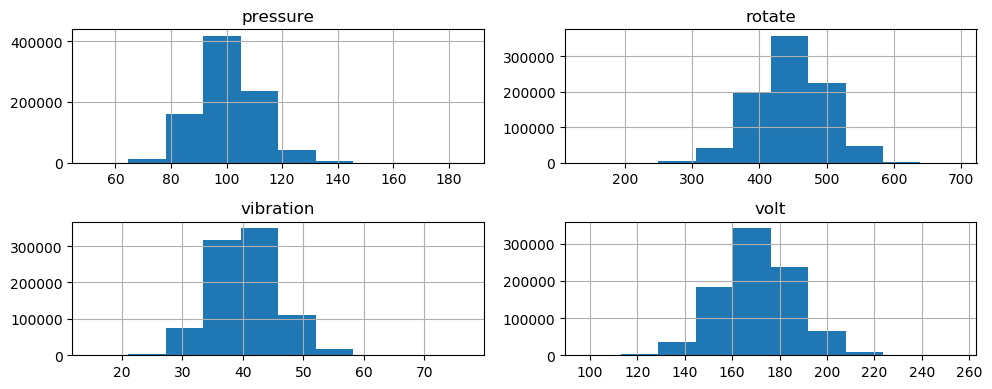

In [5]:
print 'Distributions of sensor data:'
plt.rcParams["figure.dpi"] = 100
telemetry_df[['pressure','rotate','vibration','volt']].hist(figsize=(10,4))
plt.tight_layout()
plt.savefig(plotdir+'sensor_distributions.png')
plt.show()

Next look at the machines' age by model.  That shows three years where all types of machines were purchased: yrs(2,10,and 20).  Let's look at error codes for years 2 and 20.

In [6]:
machs=machines_df.pivot_table(index='model',columns='age',values='machineID',aggfunc='max')
machs.fillna(' ',inplace=True)
machs

age,0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20
model,,,,,,,,,,,,,,,,,,,,
model1,,,92.0,16,,58,,42,,,56.0,31,,99.0,49,85.0,35,,,24.0
model2,,,90.0,,40,,47,,,,96.0,,87,97.0,,20.0,,95,69,98.0
model3,,14,86.0,26,,53,80,6,3,84,68.0,82,,79.0,65,8.0,89,93,75,64.0
model4,39,81,72.0,60,74,100,66,44,,41,57.0,,77,88.0,38,25.0,91,83,78,62.0


# Build first dataframe for analysis

Because the number of entries in each of the datafiles is different, but all have a unifying timestamp, the dataframe will be built left to right starting with telemtry_df (the file with all timestamps) and how='left' for all merges.  As a first pass, telemetryfeat_df which is a premade lag function on the telemtry data will not be used.  A similar function will be created here.

As a first pass, we will use only the following three files:  telmetry, machines, errors, and failures.  Without the maintainence data, this represents roughly what would be available in the real world.  Start with telemtrics as that has one entry per machine per hour, merge in other files, and then deal with missing values.

In [7]:
df_all=telemetry_df.copy()

dforder=[telemetry_df,machines_df,errors_df,failures_df]
dfordernames=['telemetry_df','machines_df','errors_df','failures_df']

print ''
for f in range(1,len(dfordernames)):
    tmp2=dforder[f].copy()
    
    if dfordernames[f]=='machines_df':
        df_all=pd.merge(df_all,tmp2,on='machineID',how='left')
        
    else:
        if dfordernames[f]=='failures_df':
            tmp2['fails']=1
        tmp2['zipper']=zip(tmp2.machineID.values,tmp2.dt1)
        del tmp2['machineID']
        del tmp2['dt1']
        del tmp2['date_str']
        del tmp2['hour']
        del tmp2['dow']
        df_all=pd.merge(df_all,tmp2,on='zipper',how='left')

df_all['fails']=df_all['fails'].fillna(0)
print 'unique Fails {}'.format(df_all.fails.unique())

df_all.to_csv(datadir+'basic_merged_df.csv',index=False)
print 'All Files done'

del tmp2,dforder,dfordernames
gc.collect()
df_all.head()


unique Fails [0. 1.]
All Files done


,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1, 2015-01-01 06:00:00)",model3,18,NaN,0.0
1,1,162.879223,402.747490,95.460525,43.413973,2015-01-01 07:00:00,7,Thursday,2015-1-1,"(1, 2015-01-01 07:00:00)",model3,18,NaN,0.0
2,1,170.989902,527.349825,75.237905,34.178847,2015-01-01 08:00:00,8,Thursday,2015-1-1,"(1, 2015-01-01 08:00:00)",model3,18,NaN,0.0
3,1,162.462833,346.149335,109.248561,41.122144,2015-01-01 09:00:00,9,Thursday,2015-1-1,"(1, 2015-01-01 09:00:00)",model3,18,NaN,0.0
4,1,157.610021,435.376873,111.886648,25.990511,2015-01-01 10:00:00,10,Thursday,2015-1-1,"(1, 2015-01-01 10:00:00)",model3,18,NaN,0.0


__ Convert errorID to tidy data and merge into tmp1 __


In [8]:
tmp2=df_all.copy()
before=tmp2.columns
tmp2['e_id']=0
tmp2['e_id'][tmp2.errorID.isnull()==0]=1
tmp2=tmp2.pivot_table(index='zipper',columns='errorID',values='e_id',aggfunc='sum')
tmp2.reset_index(drop=False,inplace=True)
tmp2.fillna(0,inplace=True)
tmp2['tot_err']=tmp2[['error1','error2','error3','error4','error5']].sum(axis=1)

df_all=pd.merge(df_all,tmp2,on='zipper',how='left')

df_all.fillna(0,inplace=True)
after=df_all.columns
print 'Changes= {}\tMax errors {}'.format(list(set(after).difference(before)),max(tmp2.tot_err))

del tmp2
gc.collect()
df_all.head(1)

C:\Users\bill_\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Changes= ['error1', 'error2', 'error3', 'error4', 'error5', 'tot_err']	Max errors 3.0


,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1, 2015-01-01 06:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



## A look at failures
Now that all information is synced by time, it is possible to look at failures across equipment age and model type. It becomes clear that there are at least a few manufacturing years that are subject to a high level of failure (specifically machines made 14 and 10 years ago) and machines that are more than 15 years old have a higher average fail rate than newer machines. It is also possible to look at error codes and their presence in the different models across time. The maintainence data is currently not available for this data set, though that would be insightful.

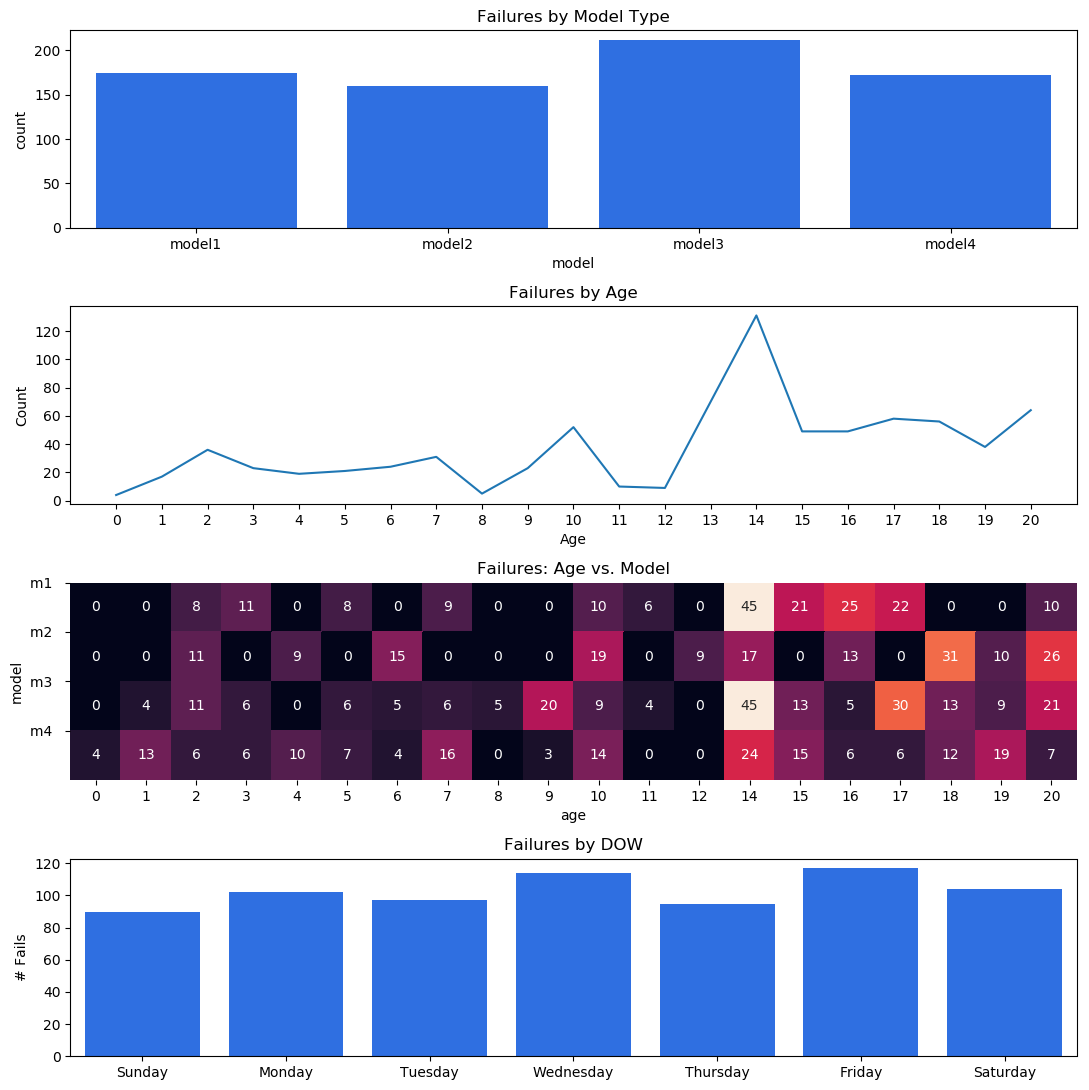

5953

In [9]:
plt.subplots(4,1,figsize=(11,11),dpi=100)
plt.subplot(4,1,1)
tmp2x=df_all.sort_values('model',ascending=True).copy()
tmp2x=tmp2x.loc[tmp2x.fails==1,:]
sns.countplot(x='model',data=tmp2x, color='#1166ff')
plt.title('Failures by Model Type')


plt.subplot(4,1,2)
tmp2x=df_all.pivot_table(index='age',values='fails',aggfunc='sum').fillna(0)
plt.plot(tmp2x.index,tmp2x.fails)
plt.xticks(range(21))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Failures by Age')


plt.subplot(4,1,3)
tmp2x=df_all.pivot_table(index='model',columns='age',values='fails',aggfunc='sum').fillna(0)
sns.heatmap(tmp2x,annot=True,cbar=False)
plt.yticks(np.arange(4),('m1  ','m2  ','m3  ','m4  '))
plt.title('Failures: Age vs. Model')


plt.subplot(4,1,4)
days=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
tmp2x=df_all.copy()
tmp2x=tmp2x.loc[tmp2x.fails==1,:]
fails=tmp2x.pivot_table(index='dow',values='fails',aggfunc='count')
#fails['fails']=fails['fails']*len(tmp1.fails)
fails['day']=fails.index.values


ax=sns.barplot(y='fails',data=fails,x='day',color='#1166ff',order=days)
ax.set(xlabel='', ylabel='# Fails')
ax.set_title('Failures by DOW')

plt.tight_layout()
plt.savefig(plotdir+'Failures.png')
plt.show()
del tmp2x
gc.collect()

In [10]:
num_days=len(df_all.date_str.unique())
print 'There are {} days in the data, but for analysis purposes,'.format(len(df_all.date_str.unique())),
print 'hours is the right unit of time \n(all measurements are reported on the hour.)',
print 'So the max possible run length is {} hours'.format(366*24)
bob=df_all.loc[df_all.fails==1,:]
print '\nAverage hours between failures during observation period'
bob=bob.pivot_table(index='machineID',columns='model',values='fails',aggfunc='count').mean()
#print (1/bob*num_days*24).round(0)
print '{}'.format((1/bob*num_days*24).apply(int))
del bob

There are 366 days in the data, but for analysis purposes, hours is the right unit of time 
(all measurements are reported on the hour.) So the max possible run length is 8784 hours

Average hours between failures during observation period
model
model1     803
model2     933
model3    1408
model4    1583
dtype: int64


## Time series metrics for model types ##

Its important to note what variables we have at this point, and how we can use them.

__fails__: Measured predominantly at 6am, this shows whether the machine has fails.  This will eventually be the target variable.

__error1-5__: Measured hourly, the value is 1 if an error was present, and 0 if it is not.

__num_ex_m__: Mean number of errorx codes for model type

__num_ex_std__: Standard deviation of errorx codes for model type

__ex_h__: num_ex_m + num_ex_std

__ex_l__: num_ex_m - num_ex_std

__e1_mdays__: Is the mean number of __DAYS__ between events and is calculated by 366 (total days in data set) / __num_ex_m__  

__e1_hdays__:  366/__ex_l__

__e1_ldays__:  366/__ex_h__

In the next step, actual runtimes will be calulated on a per machine per model level.  These variables will allow us to characterize the individual run as long or short relative to the machine average for that failure/error code.  The next code cell shows the event desities by model.  The distributions are different, but it is worth looking for additional features with larger differences.

In [11]:
df_all.to_csv(datadir+'df_all_errorn.csv')
gc.collect()
df_all.head(1)

,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1, 2015-01-01 06:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
class UpTime():
    
    def __init__(self):
        self.last_error_time=0
        self.last_error=0
        self.last_machine=0
        self.run_count=0
        self.errcount=0
        self.last_max=0

    def get_uptime(self,machine,error,datet):
        
        if self.last_machine!=machine:
            self.last_machine=machine
            self.last_error_time=datet
            self.last_error=0
            self.flag=False
            return 0.0
        
        if error == 0:
            return (datet-self.last_error_time).total_seconds()/3600.
        
        self.last_error=datet
        return 0.0
    
    def get_uptime2(self,machine,error,datet):
        
        if self.last_machine!=machine:
            self.last_machine=machine
            self.last_error_time=datet
            self.last_error=0
            self.flag=False
            return datet
        
        if error == 0:
            return self.last_error_time
        
        if error >=1:
            tmp=self.last_error_time
            self.last_error_time=datet
            return tmp
    
    def get_run_number(self,error,machine):
        '''Generate grouping label (run number) for continuous running'''
        
        if machine!= self.last_machine:
            self.last_machine=machine
            self.last_error=0
            self.run_count=1
            return self.run_count
        
        elif error==0:
            return self.run_count
        
        elif error==1:
            tmp=self.run_count
            self.run_count+=1
            return tmp
        
        else:
            return -5

In [13]:
start=datetime.datetime.now()

ut=UpTime()
df_all['last_error']=df_all.apply(lambda x: ut.get_uptime2(x.machineID,x.fails,x.dt1),axis=1)
df_all['tm_from_fail']=(df_all['dt1']-df_all['last_error']).dt.total_seconds()/3600.
df_all['run_num']=df_all.apply(lambda x: ut.get_run_number(x.fails,x.machineID),axis=1)

a=datetime.datetime.now()
print 'Done: failures',

for e in range(1,6):
    err='error'+str(e)

    df_all['tmp']=df_all[err]

    df_all['last_error']=df_all.apply(lambda x: ut.get_uptime2(x.machineID,x.tmp,x.dt1),axis=1)
    #df_all['tm_from_e'+str(e)]=map(lambda x: x.total_seconds()/3600.,(df_all['dt1']-df_all['last_error']))
    
    df_all['tm_from_e'+str(e)]=(df_all['dt1']-df_all['last_error']).dt.total_seconds()/3600.
    df_all['run_num_e'+str(e)]=df_all.apply(lambda x: ut.get_run_number(x.tmp,x.machineID),axis=1)
    
    a=datetime.datetime.now()

    print '{} '.format(err),


del df_all['tmp'],df_all['last_error']
a=datetime.datetime.now()
print '\n\nTotal elapsed time= {:2.1f} minutes'.format((a-start).total_seconds()/60.),'\t',
gc.collect()
check_mem()
df_all.loc[df_all.machineID==2,:].head(1)

Done: failures error1  error2  error3  error4  error5  

Total elapsed time= 15.0 minutes 	Memory: 8.4gb tot  4.3gb free  50.9% free


,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err,tm_from_fail,run_num,tm_from_e1,run_num_e1,tm_from_e2,run_num_e2,tm_from_e3,run_num_e3,tm_from_e4,run_num_e4,tm_from_e5,run_num_e5
8763,2,176.558913,424.624162,76.005332,43.767049,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(2, 2015-01-01 06:00:00)",model4,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1


The following plots use the error code and failure time data derived above and show some interesting things.  First, the model performance variation is clearly present, but, it is not very large in terms of run time prediction.  However, age of machine shows some large differences. 

First, the density profiles for different ages are clearly different.  When we look at mean run times across age, there is a very clear difference and a large fall off at year 12.  It is likely that this is due to some significant physical change (ie. warranty expiration, major design change, etc.) that could be evaluated, but is not available from this data.

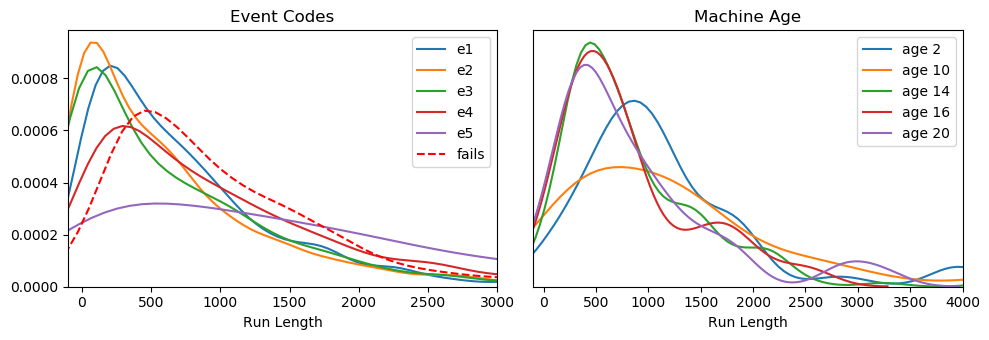

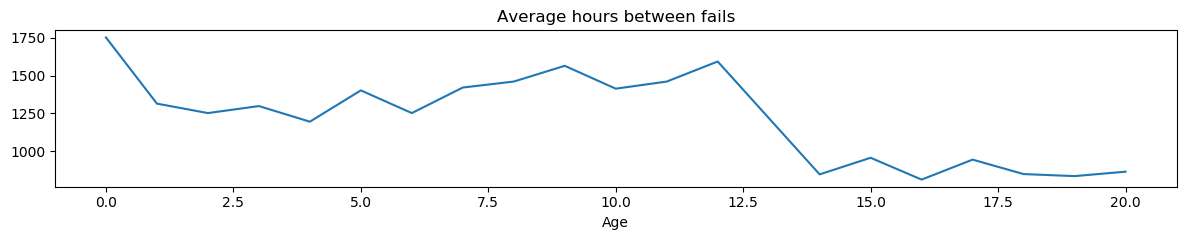

In [14]:
plt.subplots(1,2,figsize=(10,3.5),dpi=100,sharey=True)

plt.subplot(1,2,1)
for e in range(1,6):
    sns.kdeplot(df_all.groupby(['model','machineID','run_num_e'+str(e)])['tm_from_e'+str(e)].max(),label='e'+str(e))

sns.kdeplot(df_all.groupby(['model','machineID','run_num'])['tm_from_fail'].max(),color='red',lineStyle='--',label='fails')
plt.xlim(-100,3000)
plt.xlabel('Run Length')
plt.title('Event Codes')

plt.subplot(1,2,2)
ages=[2,10,14,16,20]
for a in ages:
    
    tmp4=df_all.loc[df_all.age==a,:]
    sns.kdeplot(tmp4.groupby(['machineID','run_num'])['tm_from_fail'].max(),label='age {}'.format(a))
plt.xlim(-100,4000)
plt.title('Machine Age')
plt.xlabel('Run Length')
plt.yticks([],[])
plt.tight_layout()
plt.savefig(plotdir+'Event_Mach_dists.png')
plt.show()

plt.figure(figsize=(12,2.5),dpi=100)
tmp6=df_all.groupby(['machineID','age','run_num'])['tm_from_fail'].max()
tmp6=pd.DataFrame(tmp6)
plt.plot(tmp6.groupby('age')['tm_from_fail'].mean())
plt.title('Average hours between fails')
plt.xlabel('Age')
plt.tight_layout()
plt.savefig(plotdir+"Avg_Hours_between_fails.png")
plt.show()
del tmp6,tmp4

The following code uses the failure and error code data to develop four groupings for for the times between event (mean time and mean time +/- 1 sigma).  The resulting dataframe has lots of columns, but is conceptually simple.  Most of these features will get removed later, as only the most relevent columns will survive the PCA process.

One quick note, the next boxplot shows the run lengths across machine age.  Superimposed is a line that shows mean + 1 sigma.  It is clear that as a feature, this would correlate well to long runs and serve as a good indicator of machines unlikely to fail in the near term (machines that are healthy, tend to stay healthy in this case.)

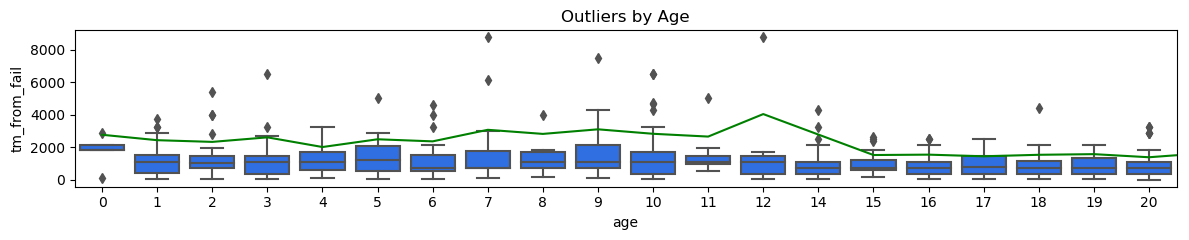

In [15]:
bob=df_all.groupby(['age','machineID','run_num'])['tm_from_fail'].max()
bob=pd.DataFrame(bob)

age_m=bob.groupby('age')['tm_from_fail'].mean()
age_sdev=bob.groupby('age')['tm_from_fail'].std()
tom=pd.DataFrame()
tom['low']=age_m-age_sdev
tom['mean']=age_m
tom['high']=age_m+age_sdev

plt.figure(figsize=(12,2.5),dpi=100)
al=bob.reset_index(drop=False)
al.loc[al.age==4,:].head(25)
sns.boxplot(x='age',y='tm_from_fail',data=al,color='#1166ff')
plt.plot(tom.high,color='green')
plt.title('Outliers by Age')
plt.tight_layout()
plt.savefig(plotdir+'Outliers_by_age.png')
plt.show()

del age_m,age_sdev,al,tom,bob

In [16]:
# Generate high low for age and model
events=['fail','e1','e2','e3','e4','e5',]
parameters=['age','model']

high_low_list=[]
for p in parameters:
    
    for j,e in enumerate(events):
        bob=df_all.groupby([p,'machineID','run_num'])['tm_from_'+e].max()
        bob=pd.DataFrame(bob)
        age_m=bob.groupby(p)['tm_from_'+e].mean()
        age_sdev=bob.groupby(p)['tm_from_'+e].std()
        tom=pd.DataFrame()
        label=p+'_'+e+'_'
        tom[label+'low']=age_m-age_sdev
        tom[label+'mean']=age_m
        tom[label+'high']=age_m+age_sdev
        tom.reset_index(drop=False,inplace=True)
        if j==0:
            tmp=tom
        else:
            tmp=pd.merge(tmp,tom,how='left')
    high_low_list.append(tmp)
    
del bob,tom,tmp,age_m,age_sdev
high_low_list[0].head()

,age,age_fail_low,age_fail_mean,age_fail_high,age_e1_low,age_e1_mean,age_e1_high,age_e2_low,age_e2_mean,age_e2_high,age_e3_low,age_e3_mean,age_e3_high,age_e4_low,age_e4_mean,age_e4_high,age_e5_low,age_e5_mean,age_e5_high
0,0,738.728072,1752.000000,2765.271928,1091.961857,2505.600000,3919.238143,321.931508,1257.400000,2192.868492,304.775406,1204.600000,2104.424594,855.302561,1322.000000,1788.697439,1536.128585,3345.600000,5155.071415
1,1,196.601894,1314.000000,2431.398106,393.285562,1111.250000,1829.214438,433.227784,982.600000,1531.972216,369.299756,1179.450000,1989.600244,472.142517,1692.900000,2913.657483,906.077461,2064.100000,3222.122539
2,2,175.852761,1251.428571,2327.004382,386.184531,924.833333,1463.482136,427.609349,1438.000000,2448.390651,485.107055,1534.738095,2584.369135,280.447092,1585.047619,2889.648146,810.779480,3141.690476,5472.601472
3,3,-10.856223,1297.777778,2606.411779,416.404926,914.740741,1413.076555,316.188778,1224.703704,2133.218629,301.724086,1092.481481,1883.238877,592.971822,1246.481481,1899.991141,880.467351,2995.259259,5110.051167
4,4,378.783075,1194.545455,2010.307834,504.468071,1206.000000,1907.531929,474.891943,1197.818182,1920.744420,487.858876,1108.500000,1729.141124,582.599826,1617.090909,2651.581992,1188.441296,2874.045455,4559.649613


In [17]:
#%whos

In [18]:
def get_groups(feat_name,feature, breaks):
    '''Accept feature_name,feature which is a feature column from df and breaks which is a breaklist of length 3.
    return a dataframe with q columns.  Essentially a categorical variable on group membership.'''

    df_quarts=pd.DataFrame()
    df_quarts[feat_name+'_Q1']=(feature<breaks[0])*np.ones(len(feature))
    df_quarts[feat_name+'_Q2']=((feature>=breaks[0])&(feature<breaks[1]))*np.ones(len(feature))
    df_quarts[feat_name+'_Q3']=((feature>=breaks[1])&(feature<breaks[2]))*np.ones(len(feature))
    df_quarts[feat_name+'_Q4']=(feature>breaks[2])*np.ones(len(feature))
    
    return df_quarts

In [19]:
df_all['zipper']=zip(df_all.machineID,df_all.dt1)

df_all=pd.merge(df_all,high_low_list[0],on='age', how='left')
df_all=pd.merge(df_all,high_low_list[1],on='model', how='left')
print 'have df_all'
check_mem()


events=['fail','e1','e2','e3','e4','e5',]
parameters=['age','model']

for i,p in enumerate(parameters):
    
    for e in events:
        label=p+'_'+e+'_'
        
        feat_str='tm_from_'+e
        feat_name=label
        print feat_name,
        
        breaks=[df_all[label+'low'], df_all[label+'mean'],df_all[label+'high']]
        feat_df=get_groups(feat_name,df_all[feat_str], breaks)
        del breaks
        
        merge_cols=[x for x in feat_df.columns if x.find('Q')>=0]
        df_all[merge_cols]=feat_df[merge_cols]
        del feat_df
    
    print ' done'

gc.collect
check_mem()
df_all.head()

have df_all
Memory: 8.4gb tot  3.6gb free  42.7% free
age_fail_ age_e1_ age_e2_ age_e3_ age_e4_ age_e5_  done
model_fail_ model_e1_ model_e2_ model_e3_ model_e4_ model_e5_  done
Memory: 8.4gb tot  3.1gb free  37.4% free


,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err,tm_from_fail,run_num,tm_from_e1,run_num_e1,tm_from_e2,run_num_e2,tm_from_e3,run_num_e3,tm_from_e4,run_num_e4,tm_from_e5,run_num_e5,age_fail_low,age_fail_mean,age_fail_high,age_e1_low,age_e1_mean,age_e1_high,age_e2_low,age_e2_mean,age_e2_high,age_e3_low,age_e3_mean,age_e3_high,age_e4_low,age_e4_mean,age_e4_high,age_e5_low,age_e5_mean,age_e5_high,model_fail_low,model_fail_mean,model_fail_high,model_e1_low,model_e1_mean,model_e1_high,model_e2_low,model_e2_mean,model_e2_high,model_e3_low,model_e3_mean,model_e3_high,model_e4_low,model_e4_mean,model_e4_high,model_e5_low,model_e5_mean,model_e5_high,age_fail__Q1,age_fail__Q2,age_fail__Q3,age_fail__Q4,age_e1__Q1,age_e1__Q2,age_e1__Q3,age_e1__Q4,age_e2__Q1,age_e2__Q2,age_e2__Q3,age_e2__Q4,age_e3__Q1,age_e3__Q2,age_e3__Q3,age_e3__Q4,age_e4__Q1,age_e4__Q2,age_e4__Q3,age_e4__Q4,age_e5__Q1,age_e5__Q2,age_e5__Q3,age_e5__Q4,model_fail__Q1,model_fail__Q2,model_fail__Q3,model_fail__Q4,model_e1__Q1,model_e1__Q2,model_e1__Q3,model_e1__Q4,model_e2__Q1,model_e2__Q2,model_e2__Q3,model_e2__Q4,model_e3__Q1,model_e3__Q2,model_e3__Q3,model_e3__Q4,model_e4__Q1,model_e4__Q2,model_e4__Q3,model_e4__Q4,model_e5__Q1,model_e5__Q2,model_e5__Q3,model_e5__Q4
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1, 2015-01-01 06:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,162.879223,402.747490,95.460525,43.413973,2015-01-01 07:00:00,7,Thursday,2015-1-1,"(1, 2015-01-01 07:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,1,1.0,1,1.0,1,1.0,1,1.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,170.989902,527.349825,75.237905,34.178847,2015-01-01 08:00:00,8,Thursday,2015-1-1,"(1, 2015-01-01 08:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,2.0,1,2.0,1,2.0,1,2.0,1,2.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,162.462833,346.149335,109.248561,41.122144,2015-01-01 09:00:00,9,Thursday,2015-1-1,"(1, 2015-01-01 09:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1,3.0,1,3.0,1,3.0,1,3.0,1,3.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,117

## Understanding the sensor inputs
It is important to add some features which account for sensor inputs over time. We can take advantage of some attributes of the failure data, specifically that the failure data only happens at 3am (17 times) and 6am (the remaining 98% of fails.) Two cummulative lag functions will be created (3hr and 24hr means) which ignore missing values.) As a first pass, the modeled df will contain only data for those two hours. 
Additionally, we will create features that show whether the the sensor outputs are more than +/-1 sigma from the machine's overall mean.

In [20]:
# Sensor start
sensors=['volt','rotate','pressure','vibration']

df_all=df_all.sort_values(['machineID','zipper'],ascending=[True,True])

for s in sensors:
    df_all[s+'__roll3']=df_all.groupby('machineID')[s].rolling(3,1).mean().reset_index(0,drop=True)
    df_all[s+'__roll24']=df_all.groupby('machineID')[s].rolling(24,1).mean().reset_index(0,drop=True)
    df_all[s+'__3sdev']=df_all.groupby('machineID')[s].rolling(3,1).std().reset_index(0,drop=True)
    df_all[s+'__24sdev']=df_all.groupby('machineID')[s].rolling(24,1).std().reset_index(0,drop=True)
    df_all[s+'__24max']=df_all.groupby('machineID')[s].rolling(24,1).max().reset_index(0,drop=True)
    df_all[s+'__24min']=df_all.groupby('machineID')[s].rolling(24,1).min().reset_index(0,drop=True)

df_all.head(2)

,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err,tm_from_fail,run_num,tm_from_e1,run_num_e1,tm_from_e2,run_num_e2,tm_from_e3,run_num_e3,tm_from_e4,run_num_e4,tm_from_e5,run_num_e5,age_fail_low,age_fail_mean,age_fail_high,age_e1_low,age_e1_mean,age_e1_high,age_e2_low,age_e2_mean,age_e2_high,age_e3_low,age_e3_mean,age_e3_high,age_e4_low,age_e4_mean,age_e4_high,age_e5_low,age_e5_mean,age_e5_high,model_fail_low,model_fail_mean,model_fail_high,model_e1_low,model_e1_mean,model_e1_high,model_e2_low,model_e2_mean,model_e2_high,model_e3_low,model_e3_mean,model_e3_high,model_e4_low,model_e4_mean,model_e4_high,model_e5_low,model_e5_mean,model_e5_high,age_fail__Q1,age_fail__Q2,age_fail__Q3,age_fail__Q4,age_e1__Q1,age_e1__Q2,age_e1__Q3,age_e1__Q4,age_e2__Q1,age_e2__Q2,age_e2__Q3,age_e2__Q4,age_e3__Q1,age_e3__Q2,age_e3__Q3,age_e3__Q4,age_e4__Q1,age_e4__Q2,age_e4__Q3,age_e4__Q4,age_e5__Q1,age_e5__Q2,age_e5__Q3,age_e5__Q4,model_fail__Q1,model_fail__Q2,model_fail__Q3,model_fail__Q4,model_e1__Q1,model_e1__Q2,model_e1__Q3,model_e1__Q4,model_e2__Q1,model_e2__Q2,model_e2__Q3,model_e2__Q4,model_e3__Q1,model_e3__Q2,model_e3__Q3,model_e3__Q4,model_e4__Q1,model_e4__Q2,model_e4__Q3,model_e4__Q4,model_e5__Q1,model_e5__Q2,model_e5__Q3,model_e5__Q4,volt__roll3,volt__roll24,volt__3sdev,volt__24sdev,volt__24max,volt__24min,rotate__roll3,rotate__roll24,rotate__3sdev,rotate__24sdev,rotate__24max,rotate__24min,pressure__roll3,pressure__roll24,pressure__3sdev,pressure__24sdev,pressure__24max,pressure__24min,vibration__roll3,vibration__roll24,vibration__3sdev,vibration__24sdev,vibration__24max,vibration__24min
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1, 2015-01-01 06:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,176.217853,176.217853,NaN,NaN,176.217853,176.217853,418.504078,418.504078,NaN,NaN,418.504078,418.504078,113.077935,113.077935,NaN,NaN,113.077935,113.077935,45.087686,45.087686,NaN,NaN,45.087686,45.087686
1,1,162.879223,402.747490,95.460525,43.413973,2015-01-01 07:00:00,7,Thursday,2015-1-1,"(1, 2015-01-01 07:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,1,1.0,1,1.0,1,1.0,1,1.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,169.548538,169.548538,9.431836,9.431836,176.217853,162.879223,410.625784,410.625784,11.141591,11.141591,418.504078,402.747490,104.269230,104.269230,12.45739,12.45739,113.077935,95.460525,44.250829,44.250829,1.183494,1.183494,45.087686,43.413973


In [21]:
# Add max, min, std features

mach_means=df_all.pivot_table(index='machineID',values=['volt','rotate','pressure','vibration'],aggfunc='mean')
mach_std=df_all.pivot_table(index='machineID',values=['volt','rotate','pressure','vibration'],aggfunc='std')
mach_lows=mach_means-mach_std
mach_highs=mach_means+mach_std

mach_means.columns=[x[:3]+'_mn' for x in mach_means]
mach_std.columns=[x[:3]+'_std' for x in mach_std]
mach_lows.columns=[x[:3]+'_low' for x in mach_lows]
mach_highs.columns=[x[:3]+'_hgh' for x in mach_std]

mach_mach=mach_means[mach_means.columns]
mach_mach[mach_lows.columns]=mach_lows[mach_lows.columns]
mach_mach[mach_highs.columns]=mach_highs[mach_highs.columns]
mach_mach[mach_std.columns]=mach_std[mach_std.columns]

tmp=['pre_low','pre_mn','pre_hgh','pre_std',
    'rot_low','rot_mn','rot_hgh','rot_std',
    'vib_low','vib_mn','vib_hgh','vib_std',
    'vol_low','vol_mn','vol_hgh','vol_std']

mach_mach=mach_mach[tmp]
mach_mach.reset_index(drop=False,inplace=True)

df_all=pd.merge(df_all,mach_mach,on='machineID')

del mach_mach,mach_lows,mach_highs,mach_std,mach_means,tmp
gc.collect()
check_mem()
df_all.head(2)

Memory: 8.4gb tot  3.5gb free  42.1% free


,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err,tm_from_fail,run_num,tm_from_e1,run_num_e1,tm_from_e2,run_num_e2,tm_from_e3,run_num_e3,tm_from_e4,run_num_e4,tm_from_e5,run_num_e5,age_fail_low,age_fail_mean,age_fail_high,age_e1_low,age_e1_mean,age_e1_high,age_e2_low,age_e2_mean,age_e2_high,age_e3_low,age_e3_mean,age_e3_high,age_e4_low,age_e4_mean,age_e4_high,age_e5_low,age_e5_mean,age_e5_high,model_fail_low,model_fail_mean,model_fail_high,model_e1_low,model_e1_mean,model_e1_high,model_e2_low,model_e2_mean,model_e2_high,model_e3_low,model_e3_mean,model_e3_high,model_e4_low,model_e4_mean,model_e4_high,model_e5_low,model_e5_mean,model_e5_high,age_fail__Q1,age_fail__Q2,age_fail__Q3,age_fail__Q4,age_e1__Q1,age_e1__Q2,age_e1__Q3,age_e1__Q4,age_e2__Q1,age_e2__Q2,age_e2__Q3,age_e2__Q4,age_e3__Q1,age_e3__Q2,age_e3__Q3,age_e3__Q4,age_e4__Q1,age_e4__Q2,age_e4__Q3,age_e4__Q4,age_e5__Q1,age_e5__Q2,age_e5__Q3,age_e5__Q4,model_fail__Q1,model_fail__Q2,model_fail__Q3,model_fail__Q4,model_e1__Q1,model_e1__Q2,model_e1__Q3,model_e1__Q4,model_e2__Q1,model_e2__Q2,model_e2__Q3,model_e2__Q4,model_e3__Q1,model_e3__Q2,model_e3__Q3,model_e3__Q4,model_e4__Q1,model_e4__Q2,model_e4__Q3,model_e4__Q4,model_e5__Q1,model_e5__Q2,model_e5__Q3,model_e5__Q4,volt__roll3,volt__roll24,volt__3sdev,volt__24sdev,volt__24max,volt__24min,rotate__roll3,rotate__roll24,rotate__3sdev,rotate__24sdev,rotate__24max,rotate__24min,pressure__roll3,pressure__roll24,pressure__3sdev,pressure__24sdev,pressure__24max,pressure__24min,vibration__roll3,vibration__roll24,vibration__3sdev,vibration__24sdev,vibration__24max,vibration__24min,pre_low,pre_mn,pre_hgh,pre_std,rot_low,rot_mn,rot_hgh,rot_std,vib_low,vib_mn,vib_hgh,vib_std,vol_low,vol_mn,vol_hgh,vol_std
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1, 2015-01-01 06:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,176.217853,176.217853,NaN,NaN,176.217853,176.217853,418.504078,418.504078,NaN,NaN,418.504078,418.504078,113.077935,113.077935,NaN,NaN,113.077935,113.077935,45.087686,45.087686,NaN,NaN,45.087686,45.087686,89.808436,100.667673,111.52691,10.859237,394.068,446.312874,498.557749,52.244874,35.044245,40.585863,46.127482,5.541618,155.518713,170.835978,186.153242,15.317264
1,1,162.879223,402.747490,95.460525,43.413973,2015-01-01 07:00:00,7,Thursday,2015-1-1,"(1, 2015-01-01 07:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,1,1.0,1,1.0,1,1.0,1,1.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,169.548538,169.548538,9.431836,9.431836,176.217853,162.879223,410.625784,410.625784,11.141591,11.141591,418.504078,402.747490,104.269230,104.269230,12.45739,12.45739,113.077935,95.460525,44.250829,44.250829,1.183494,1.1

In [22]:
# Q1-Q4 Calculations

parameters=['volt','pressure','rotate','vibration']

for i,p in enumerate(parameters):
    
    label=p[:3]+'_'

    feat_name=label
    print feat_name,
        
    breaks=[df_all[label+'low'], df_all[label+'mn'],df_all[label+'hgh']]
    feat_df=get_groups(feat_name,df_all[parameters[i]], breaks)
        
    del breaks
        
    merge_cols=[x for x in feat_df.columns if x.find('Q')>=0]
    df_all[merge_cols]=feat_df[merge_cols]
        
    del feat_df
print ' done'

gc.collect()
check_mem()
df_all.head()

vol_ pre_ rot_ vib_  done
Memory: 8.4gb tot  3.4gb free  40.7% free


,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err,tm_from_fail,run_num,tm_from_e1,run_num_e1,tm_from_e2,run_num_e2,tm_from_e3,run_num_e3,tm_from_e4,run_num_e4,tm_from_e5,run_num_e5,age_fail_low,age_fail_mean,age_fail_high,age_e1_low,age_e1_mean,age_e1_high,age_e2_low,age_e2_mean,age_e2_high,age_e3_low,age_e3_mean,age_e3_high,age_e4_low,age_e4_mean,age_e4_high,age_e5_low,age_e5_mean,age_e5_high,model_fail_low,model_fail_mean,model_fail_high,model_e1_low,model_e1_mean,model_e1_high,model_e2_low,model_e2_mean,model_e2_high,model_e3_low,model_e3_mean,model_e3_high,model_e4_low,model_e4_mean,model_e4_high,model_e5_low,model_e5_mean,model_e5_high,age_fail__Q1,age_fail__Q2,age_fail__Q3,age_fail__Q4,age_e1__Q1,age_e1__Q2,age_e1__Q3,age_e1__Q4,age_e2__Q1,age_e2__Q2,age_e2__Q3,age_e2__Q4,age_e3__Q1,age_e3__Q2,age_e3__Q3,age_e3__Q4,age_e4__Q1,age_e4__Q2,age_e4__Q3,age_e4__Q4,age_e5__Q1,age_e5__Q2,age_e5__Q3,age_e5__Q4,model_fail__Q1,model_fail__Q2,model_fail__Q3,model_fail__Q4,model_e1__Q1,model_e1__Q2,model_e1__Q3,model_e1__Q4,model_e2__Q1,model_e2__Q2,model_e2__Q3,model_e2__Q4,model_e3__Q1,model_e3__Q2,model_e3__Q3,model_e3__Q4,model_e4__Q1,model_e4__Q2,model_e4__Q3,model_e4__Q4,model_e5__Q1,model_e5__Q2,model_e5__Q3,model_e5__Q4,volt__roll3,volt__roll24,volt__3sdev,volt__24sdev,volt__24max,volt__24min,rotate__roll3,rotate__roll24,rotate__3sdev,rotate__24sdev,rotate__24max,rotate__24min,pressure__roll3,pressure__roll24,pressure__3sdev,pressure__24sdev,pressure__24max,pressure__24min,vibration__roll3,vibration__roll24,vibration__3sdev,vibration__24sdev,vibration__24max,vibration__24min,pre_low,pre_mn,pre_hgh,pre_std,rot_low,rot_mn,rot_hgh,rot_std,vib_low,vib_mn,vib_hgh,vib_std,vol_low,vol_mn,vol_hgh,vol_std,vol__Q1,vol__Q2,vol__Q3,vol__Q4,pre__Q1,pre__Q2,pre__Q3,pre__Q4,rot__Q1,rot__Q2,rot__Q3,rot__Q4,vib__Q1,vib__Q2,vib__Q3,vib__Q4
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1, 2015-01-01 06:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,176.217853,176.217853,NaN,NaN,176.217853,176.217853,418.504078,418.504078,NaN,NaN,418.504078,418.504078,113.077935,113.077935,NaN,NaN,113.077935,113.077935,45.087686,45.087686,NaN,NaN,45.087686,45.087686,89.808436,100.667673,111.52691,10.859237,394.068,446.312874,498.557749,52.244874,35.044245,40.585863,46.127482,5.541618,155.518713,170.835978,186.153242,15.317264,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,162.879223,402.747490,95.460525,43.413973,2015-01-01 07:00:00,7,Thursday,2015-1-1,"(1, 2015-01-01 07:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,1,1.0,1,1.0,1,1.0,1,1.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,169.548538,169.548538,9.431

In [23]:
df_all.to_csv(datadir+'df_all_w_sensor_Qvalues.csv')

## Missing values:

The data is relatively clean with no missing values in the measurements.  However, some of the lag functions (specifically the rolling sdevs) have a missing value on machine transition.  For these values, the median standard deviation for the machine can be substituted.

In [24]:
#find
missing_val_cols=[x for x in df_all.columns if df_all[x].isna().any()]
for i,c in enumerate(missing_val_cols):
    tmp=df_all.loc[df_all[c].isna(),:]
    print '{}     {}\t\thours w/ missing val:{}'.format(i,c,tmp['hour'].unique())
    tmp_meds=df_all.groupby('machineID')[c].median()
    tmp_indy=tmp.index
       
    for t in tmp_indy:
        df_all.loc[t,c]=tmp_meds[df_all.loc[t,'machineID']]

#df_all.loc[range(8762,8772),:].head(5)

# Rerun check to make sure all values corrected.
missing=[]
missing_val_cols=[x for x in df_all.columns if df_all[x].isna().any()]
for i,c in enumerate(missing_val_cols):
    tmp=df_all.loc[tmp2[c].isna(),:]
    missing.append(tmp)
if missing == []:
    print "missing values repaired"
else:
    print missing
    
del tmp,tmp_meds,tmp_indy

0     volt__3sdev		hours w/ missing val:[6]
1     volt__24sdev		hours w/ missing val:[6]
2     rotate__3sdev		hours w/ missing val:[6]
3     rotate__24sdev		hours w/ missing val:[6]
4     pressure__3sdev		hours w/ missing val:[6]
5     pressure__24sdev		hours w/ missing val:[6]
6     vibration__3sdev		hours w/ missing val:[6]
7     vibration__24sdev		hours w/ missing val:[6]
missing values repaired


In [25]:
df_all.to_csv(datadir+'df_all_w_before_model.csv')

In [26]:
gc.collect()
check_mem()

Memory: 8.4gb tot  3.5gb free  41.3% free


## The Model

At this point, the data is clean and organized, and a good first pass of features is available (>170).  A few columns still need to be one converted to dummies, and temporary columns need to be deleted.  Once that is done, the focus will be on creating predictions.  However, because of the time series nature of some of the derived features, many of the techniques typically used in a data science problem (ie. random cv) can't be used.  

It will be necessary to sort the data by time, use the data from the early part of the year to train the model and predict the back part of the year.  So the first step will be to look for obvious differences.

To get a feel for how complex the model will need to be, grab a quick look at PCA for the entire data set will be done. Like many machine maintainence problems, the data is very unbalanced, with less than 2% being in the "Likely to Fail" class.  After balancing the data, PCA will be redone.  we'll choose feature depth at this point.

A simple logistic regression will be used to get a feel for how the balanced data set performs.  If necessary, a random forest model will be developed for comparison.

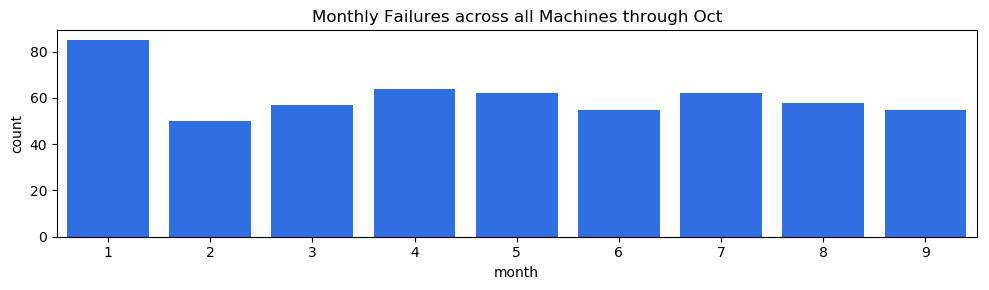

In [27]:
# look at relative fails early in the year vs late in the year.  Since this is an excercise, assume that we don't
# know the results in months 10-12

plt.figure(figsize=(10,3),dpi=100)
df_all['month']=df_all['date_str'].apply((lambda x: int(x.split('-')[1])))
tmp=df_all.loc[(df_all.fails==1)&(df_all.month<=9),['month','fails']]
sns.countplot(x='month',data=tmp,order=range(1,10),color="#1166ff")
plt.title("Monthly Failures across all Machines through Oct")
plt.tight_layout()
plt.savefig(plotdir+'Monthly_failures_throug_Oct.png')
plt.show()

This plot shows that January has a disproportionately high number of failures, and may not be representative of steady state conditions.  For a first pass, it will remain in the data, but it may be worth dropping January from the training data.

## Build a target class: Likely to fail within 24 hours

Because failures are measured only at 6am, ew need to creat a target that will measure a "likely to fail" parameter.

In [28]:
check_mem()
del tmp
gc.collect()
check_mem()

Memory: 8.4gb tot  3.5gb free  41.4% free
Memory: 8.4gb tot  3.5gb free  41.4% free


In [29]:

check_mem()

df_new=df_all[['dt1','machineID','fails']].copy()
df_new['f24']=df_new.fails

ends=df_all.groupby('machineID')['fails'].nth([-1])

print 'Shifting ',
for h in range(1,24):
    shft=0-h
    df_new['f24']=df_new['f24']+df_new.groupby('machineID')['fails'].shift(shft)
    print h,
print ''

# In training data, all machines end running, none on fails.  Allow for fail possibility.
print 'Filling empty values for machine:'
for m in range(1,101):
    df_new.loc[(df_all.machineID==m)&(df_new['f24'].isna()),'f24']=ends[m]
    print m,
print ''

df_new.loc[df_new.f24>1,'f24']=1

del df_new['dt1'],df_new['machineID']

df_all['f24']=df_new['f24'].values

print '\nNumber of hours in likely to fail window: \n{}'.format(df_new.f24.sum())
del df_new
df_all.head(1)

Memory: 8.4gb tot  3.5gb free  41.4% free
Shifting  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 
Filling empty values for machine:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

Number of hours in likely to fail window: 
17201.0


,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err,tm_from_fail,run_num,tm_from_e1,run_num_e1,tm_from_e2,run_num_e2,tm_from_e3,run_num_e3,tm_from_e4,run_num_e4,tm_from_e5,run_num_e5,age_fail_low,age_fail_mean,age_fail_high,age_e1_low,age_e1_mean,age_e1_high,age_e2_low,age_e2_mean,age_e2_high,age_e3_low,age_e3_mean,age_e3_high,age_e4_low,age_e4_mean,age_e4_high,age_e5_low,age_e5_mean,age_e5_high,model_fail_low,model_fail_mean,model_fail_high,model_e1_low,model_e1_mean,model_e1_high,model_e2_low,model_e2_mean,model_e2_high,model_e3_low,model_e3_mean,model_e3_high,model_e4_low,model_e4_mean,model_e4_high,model_e5_low,model_e5_mean,model_e5_high,age_fail__Q1,age_fail__Q2,age_fail__Q3,age_fail__Q4,age_e1__Q1,age_e1__Q2,age_e1__Q3,age_e1__Q4,age_e2__Q1,age_e2__Q2,age_e2__Q3,age_e2__Q4,age_e3__Q1,age_e3__Q2,age_e3__Q3,age_e3__Q4,age_e4__Q1,age_e4__Q2,age_e4__Q3,age_e4__Q4,age_e5__Q1,age_e5__Q2,age_e5__Q3,age_e5__Q4,model_fail__Q1,model_fail__Q2,model_fail__Q3,model_fail__Q4,model_e1__Q1,model_e1__Q2,model_e1__Q3,model_e1__Q4,model_e2__Q1,model_e2__Q2,model_e2__Q3,model_e2__Q4,model_e3__Q1,model_e3__Q2,model_e3__Q3,model_e3__Q4,model_e4__Q1,model_e4__Q2,model_e4__Q3,model_e4__Q4,model_e5__Q1,model_e5__Q2,model_e5__Q3,model_e5__Q4,volt__roll3,volt__roll24,volt__3sdev,volt__24sdev,volt__24max,volt__24min,rotate__roll3,rotate__roll24,rotate__3sdev,rotate__24sdev,rotate__24max,rotate__24min,pressure__roll3,pressure__roll24,pressure__3sdev,pressure__24sdev,pressure__24max,pressure__24min,vibration__roll3,vibration__roll24,vibration__3sdev,vibration__24sdev,vibration__24max,vibration__24min,pre_low,pre_mn,pre_hgh,pre_std,rot_low,rot_mn,rot_hgh,rot_std,vib_low,vib_mn,vib_hgh,vib_std,vol_low,vol_mn,vol_hgh,vol_std,vol__Q1,vol__Q2,vol__Q3,vol__Q4,pre__Q1,pre__Q2,pre__Q3,pre__Q4,rot__Q1,rot__Q2,rot__Q3,rot__Q4,vib__Q1,vib__Q2,vib__Q3,vib__Q4,month,f24
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1, 2015-01-01 06:00:00)",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,176.217853,176.217853,12.341544,14.762877,176.217853,176.217853,418.504078,418.504078,42.019344,49.66874,418.504078,418.504078,113.077935,113.077935,8.249437,9.957643,113.077935,113.077935,45.087686,45.087686,4.248164,5.042026,45.087686,45.087686,89.808436,100.667673,111.52691,10.859237,394.068,446.312874,498.557749,52.244874,35.044245,40.585863,46.127482,5.541618,155.518713,170.835978,186.153242,15.317264,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0


## Unbalanced data:

Not surprisingly in a machine maintainence application, the data is significantly unbalanced (approximately 50-1) even after expanding the target to 24 hours/fail.  

Given the result of the PCA analysis above, I want to start with a model that has approximately 50 features.  If we assume that we want much a long dataset, rows/columns should be > 10X.  We will over design for now, and assume 25x.  We should also assume that the test set will be 25% of the data.

Additionally, because of the time series nature of some of the features, random sampling is not recomended.  So, we will select the last 25% of calander days as the test set.  Essentially, that gives us a cutoff of Sept.30

As a first pass, try and sample the same number of readings that are not in the 24 hour window.  This may need adjustment later, as the distributions of machines in the train and test sets are similar, but not the same.

In [30]:
gc.collect()
check_mem()

Memory: 8.4gb tot  3.5gb free  41.9% free


In [31]:

month=df_all['month']
train_lines=month[month<10]
test_lines=month[month>=10]

df_train=df_all.loc[df_all.month<10,:].copy()
df_test=df_all.loc[df_all.month>=10,:].copy()

df_train.drop('month',inplace=True,axis=1)
df_test.drop('month',inplace=True,axis=1)

print 'Train has {} lines and {} fails '.format(len(train_lines),df_train.fails.sum()),
print 'and {} in the 24 hr window'.format(df_train.f24.sum())
print 'Test has {} lines and {} fails '.format(len(df_test),df_test.fails.sum()),
print 'and {} in the 24 hr window'.format(df_test.f24.sum())

Train has 655523 lines and 548.0 fails  and 13148.0 in the 24 hr window
Test has 220880 lines and 171.0 fails  and 4053.0 in the 24 hr window


Memory: 8.4gb tot  2.3gb free  27.9% free
Memory: 8.4gb tot  1.4gb free  16.5% free


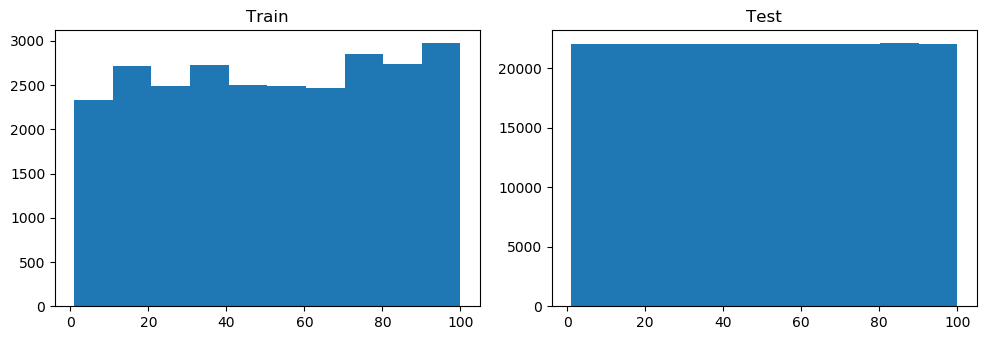

In [32]:
#Creat a balanced data set

check_mem()

df_train_f=df_train.loc[df_train.f24==1,:]
df_train_p=df_train.loc[df_train.fails==0,:]

a=list(random.sample(df_train_p.index,len(df_train_f.f24)))
df_bal=df_train_p.loc[a,:].append(df_train_f)

check_mem()
plt.subplots(1,2,figsize=(10,3.5),dpi=100)

plt.subplot(1,2,1)
plt.hist(df_bal['machineID'])
plt.title('Train')
#plt.xlabel('Machine ID')

plt.subplot(1,2,2)
plt.hist(df_test['machineID'])
plt.title('Test')
#plt.xlabel('Machine ID')
plt.tight_layout()
plt.show()


In [33]:
df_all.to_csv('C:\\Users\\bill_\\df_all.csv')
del df_all
gc.collect()
check_mem()

Memory: 8.4gb tot  2.5gb free  30.1% free


In [34]:
df_bal.to_csv("C:\\Users\\bill_\\df_bal.csv")

In [35]:
# Need to drop some temporary columns, need to drop month because train=0-9, test=10-12

cols_to_drop=['zipper','date_str','errorID','dt1']
dummies=['dow','model']

df_bal.drop(cols_to_drop,inplace=True,axis=1)
df_bal=pd.get_dummies(df_bal,prefix='D',drop_first=True)

df_test.drop(cols_to_drop,inplace=True,axis=1)
df_test=pd.get_dummies(df_test,prefix='D',drop_first=True)

gc.collect()
check_mem()
df_bal.head(2)

Memory: 8.4gb tot  2.5gb free  29.9% free


,machineID,volt,rotate,pressure,vibration,hour,age,fails,error1,error2,error3,error4,error5,tot_err,tm_from_fail,run_num,tm_from_e1,run_num_e1,tm_from_e2,run_num_e2,tm_from_e3,run_num_e3,tm_from_e4,run_num_e4,tm_from_e5,run_num_e5,age_fail_low,age_fail_mean,age_fail_high,age_e1_low,age_e1_mean,age_e1_high,age_e2_low,age_e2_mean,age_e2_high,age_e3_low,age_e3_mean,age_e3_high,age_e4_low,age_e4_mean,age_e4_high,age_e5_low,age_e5_mean,age_e5_high,model_fail_low,model_fail_mean,model_fail_high,model_e1_low,model_e1_mean,model_e1_high,model_e2_low,model_e2_mean,model_e2_high,model_e3_low,model_e3_mean,model_e3_high,model_e4_low,model_e4_mean,model_e4_high,model_e5_low,model_e5_mean,model_e5_high,age_fail__Q1,age_fail__Q2,age_fail__Q3,age_fail__Q4,age_e1__Q1,age_e1__Q2,age_e1__Q3,age_e1__Q4,age_e2__Q1,age_e2__Q2,age_e2__Q3,age_e2__Q4,age_e3__Q1,age_e3__Q2,age_e3__Q3,age_e3__Q4,age_e4__Q1,age_e4__Q2,age_e4__Q3,age_e4__Q4,age_e5__Q1,age_e5__Q2,age_e5__Q3,age_e5__Q4,model_fail__Q1,model_fail__Q2,model_fail__Q3,model_fail__Q4,model_e1__Q1,model_e1__Q2,model_e1__Q3,model_e1__Q4,model_e2__Q1,model_e2__Q2,model_e2__Q3,model_e2__Q4,model_e3__Q1,model_e3__Q2,model_e3__Q3,model_e3__Q4,model_e4__Q1,model_e4__Q2,model_e4__Q3,model_e4__Q4,model_e5__Q1,model_e5__Q2,model_e5__Q3,model_e5__Q4,volt__roll3,volt__roll24,volt__3sdev,volt__24sdev,volt__24max,volt__24min,rotate__roll3,rotate__roll24,rotate__3sdev,rotate__24sdev,rotate__24max,rotate__24min,pressure__roll3,pressure__roll24,pressure__3sdev,pressure__24sdev,pressure__24max,pressure__24min,vibration__roll3,vibration__roll24,vibration__3sdev,vibration__24sdev,vibration__24max,vibration__24min,pre_low,pre_mn,pre_hgh,pre_std,rot_low,rot_mn,rot_hgh,rot_std,vib_low,vib_mn,vib_hgh,vib_std,vol_low,vol_mn,vol_hgh,vol_std,vol__Q1,vol__Q2,vol__Q3,vol__Q4,pre__Q1,pre__Q2,pre__Q3,pre__Q4,rot__Q1,rot__Q2,rot__Q3,rot__Q4,vib__Q1,vib__Q2,vib__Q3,vib__Q4,f24,D_Monday,D_Saturday,D_Sunday,D_Thursday,D_Tuesday,D_Wednesday,D_model2,D_model3,D_model4
757632,87,160.084815,420.212514,92.908896,40.613743,21,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1143.0,5,234.0,6,1167.0,3,1167.0,7,8.0,8,3288.0,2,-854.258714,1592.727273,4039.713259,161.114987,993.727273,1826.339558,704.149696,1568.454545,2432.759395,57.400065,1985.727273,3914.054480,326.646835,1028.545455,1730.444075,1429.936191,4226.636364,7023.336536,157.189018,841.355932,1525.522847,327.740277,1133.689266,1939.638254,359.589634,1138.073446,1916.557258,269.265924,1358.570621,2447.875319,298.023842,1017.587571,1737.151299,78.864772,2320.327684,4561.790595,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,183.589519,171.334787,23.717540,17.617679,218.142895,140.316141,444.580256,450.711253,22.123648,41.304521,543.023897,364.752172,103.397207,98.722399,9.120196,8.142037,112.667982,80.851901,39.474345,38.893617,4.836778,5.795564,50.941995,27.783692,90.004472,101.499169,112.993866,11.494697,394.924145,446.998766,499.073387,52.074621,35.044884,40.334389,45.623894,5.289505,155.049755,170.591099,186.132442,15.541344,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,1,0,0
2202,1,182.173834,516.793753,88.906962,42.665363,0,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,666.0,3,49.0,6,191.0,3,2140.0,2,1617.0,4,2130.0,2,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.957370,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,176.693406,170

In [36]:
from sklearn.preprocessing import StandardScaler

#look only at 6am readings since that is where all the fail data is
#tmp=df_bal.loc[df_bal.hour==6,:].copy()

tmp=df_bal.copy()

# Separating out the target
y=tmp.f24.values
yt=df_test.f24.values

# Separating out the features
x=tmp.drop(['fails','f24'],axis=1).values
xt=df_test.drop(['fails','f24'],axis=1).values

# Standardizing the features
scale = StandardScaler().fit(x)

x=scale.transform(x)
xt=scale.transform(xt)

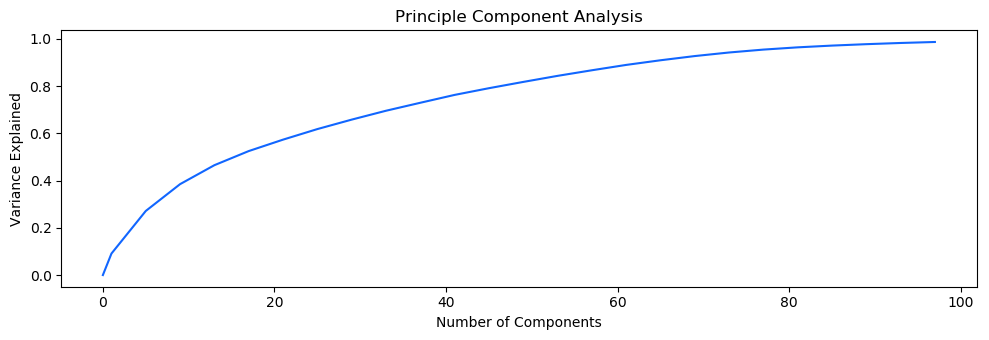

In [37]:
# Look at pca varying the available features

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

num_pcs=[0]
pcs_ex_var=[0]

#look only at 6am readings, (ignore 3am fails) since that is where most of the fail data is
#tmp=df_all.loc[df_all.hour==6,:].copy()

for i in range(1,101,4):
    #y=tmp.fails.values
    #x=tmp.drop(['fails','f24'],axis=1).values
    #x = StandardScaler().fit_transform(x)

    n_components=i
    pca = PCA(n_components=n_components)

    principalComponents = pca.fit_transform(x)

    num_pcs.append(i)
    pcs_ex_var.append(pca.explained_variance_ratio_.sum())

plt.figure(figsize=(10,3.5),dpi=100)
plt.plot(num_pcs,pcs_ex_var,color='#1166ff')
plt.title('Principle Component Analysis')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.tight_layout()
plt.savefig(plotdir+'PCA_curve.png')
plt.show()

## Develop and fit the Logistic Regression Classifier

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, precision_score

target=y
features=x

###

# First, we split the data into a training and test set, using a 70-30 split:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Now, we can perform the grid search for the logistic regression model hyperparameter:
logreg = LogisticRegression(random_state=42)    # L2 regularization is the default mode
C_vals = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
c_weight = [{0:0.1,1:0.9},{0:0.25,1:0.75},{0:0.75,1:0.25},{0:0.9,1:0.1}]
clf_grid = GridSearchCV(logreg, {'C': C_vals,'class_weight':c_weight}, cv=5, scoring='precision')
clf_grid.fit(X_train, y_train)
print 'Best Paramaters: \n',clf_grid.best_params_, clf_grid.best_score_,'\n'
print 'Accuraacy score: ',accuracy_score(clf_grid.predict(X_test), y_test),'\n'
print 'Confusion Matrix:\n',confusion_matrix(clf_grid.predict(X_test), y_test)

Best Paramaters: 
{'C': 1.0, 'class_weight': {0: 0.9, 1: 0.1}} 0.9680607836803965 

Accuraacy score:  0.8208898466218786 

Confusion Matrix:
[[3750 1319]
 [  94 2726]]


In [39]:
ypred=clf_grid.predict(xt)
print 'Predicted Accuracy Score: ',accuracy_score(ypred, yt),'\n'
print 'Confusion Matrix:\n',confusion_matrix(ypred, yt)
print '\nPrecision Score:',precision_score(yt, ypred)

log_reg_con_mat=confusion_matrix(ypred, yt)

Predicted Accuracy Score:  0.9698659905831221 

Confusion Matrix:
[[211217   1046]
 [  5610   3007]]

Precision Score: 0.34896135546013696


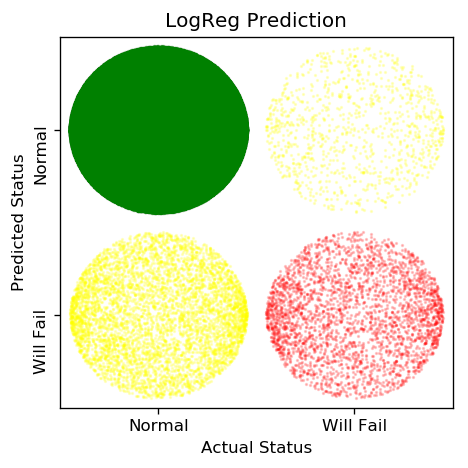

In [40]:
def get_con_mat_pts(y_true,y_pred,radius=.45,base_pt=0.5):
    
    if len(y_true) != len(y_pred):
        print 'Error.  Different lengths'
        return np.nan

    n=int(len(y_true)/2)
    m=len(y_true)-n
    
    polarity = np.array([1]*n + [-1]*m)
    np.random.shuffle(polarity)
    polarityy = np.array([1]*n + [-1]*m)
    np.random.shuffle(polarityy)
    
    scale_mex=np.random.rand(1,len(y_true))
    scale_mey=np.random.rand(1,len(y_true))
    
    bpx=np.ones(len(y_true))*base_pt
    bpy=np.ones(len(y_true))*base_pt
    
    xp=y_true
    yp=np.multiply(np.ones(len(y_true)),y_pred==0)
    
    xmag=(np.multiply(np.ones(len(y_true)),np.random.rand(1,len(y_true))))*radius*2-radius
    r2=np.multiply((np.ones(len(y_true))*radius),(np.ones(len(y_true))*radius))
    x2=np.multiply(xmag,xmag)
    
    ymag=np.multiply(np.multiply(np.sqrt(r2-x2),polarityy),scale_mey)
    
    x=bpx+xp+xmag
    y=bpy+yp+ymag

    return x,y

def plot_group(x,y,color='blue',label=''):
    '''Accepts data that is sliced by quardrant on a binary classifications confusion matrix.  Noise is added
    to fake a circular density plot.  Developed to highlight improvement in models addressing unbalanced datasets.'''

    plt.scatter(x,y,color=color,alpha=0.2,s=1,label=label)
    plt.xlim(0,2)
    plt.ylim(0,2)
    plt.xticks([0.5,1.5],['Normal','Will Fail'])
    plt.xlabel('Actual Status')
    plt.yticks([0.5,1.5],['Will Fail','Normal'],rotation=90)
    plt.ylabel('Predicted Status')
    return

df=pd.DataFrame(columns=['Actual','Predicted'])
df['Actual']=yt
df['Predicted']=ypred

colors=['green','yellow','yellow','red']
legends=['\nNormal\n','False\nNegative','\nAction\nRequired\n','False\nPositive']
i=0

plt.figure(figsize=(4,4),dpi=120)

for a in range(2):
    for b in range (2):
        tmp=df.loc[(df.Actual==a)&(df.Predicted==b),:]
        x,y=get_con_mat_pts(tmp.Actual.values,tmp.Predicted.values)
        plot_group(x,y,color=colors[i],label=legends[i])
        i+=1
plt.title('LogReg Prediction')

#plt.legend(bbox_to_anchor=(1, .85),ncol=1)
plt.tight_layout()
plt.savefig(plotdir+'LogReg_Con_Mat1.png')

plt.show()

In [41]:
check_mem()
gc.collect()
check_mem()

Memory: 8.4gb tot  1.9gb free  22.6% free
Memory: 8.4gb tot  1.9gb free  22.6% free


## Develop and fit the Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
min_samples_split = [5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
min_samples_leaf = [4, 8, 16]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf=RandomForestClassifier(random_state=42)
# Random search of parameters, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50,
                               scoring='precision',verbose=2, random_state=42, cv=3,n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

print 'Best Paramaters: \n',rf_random.best_params_, rf_random.best_score_,'\n'
print 'Accuraacy score: ',accuracy_score(rf_random.predict(X_test), y_test),'\n'
print 'Confusion Matrix:\n',confusion_matrix(rf_random.predict(X_test), y_test)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 17.5min finished


Best Paramaters: 
{'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 1000, 'max_features': 'auto', 'min_samples_split': 15, 'max_depth': 40} 0.9968112232835841 

Accuraacy score:  0.9991126885536823 

Confusion Matrix:
[[3837    0]
 [   7 4045]]


In [43]:
ypred_rf=rf_random.predict(xt)
print 'Accuraacy score: ',accuracy_score(ypred_rf, yt),'\n'
print 'Confusion Matrix:\n',confusion_matrix(ypred_rf, yt)
print '\nPrecision Score:',precision_score(yt, ypred_rf)

rnfr_con_mat=confusion_matrix(ypred_rf, yt)

Accuraacy score:  0.9989858746830859 

Confusion Matrix:
[[216614     11]
 [   213   4042]]

Precision Score: 0.9499412455934195


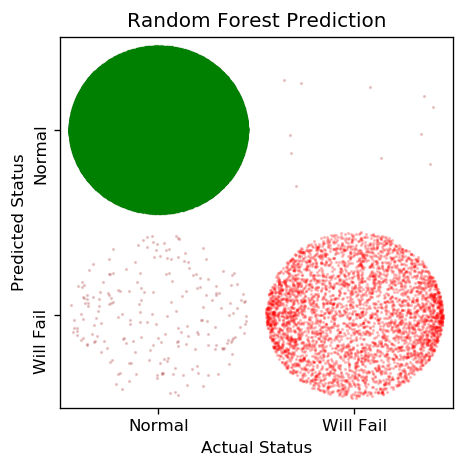

In [44]:
df=pd.DataFrame(columns=['Actual','Predicted'])
df['Actual']=yt
df['Predicted']=ypred_rf

colors=['green','brown','brown','red']
legends=['\nNormal\n','False\nNegative','\nAction\nRequired\n','False\nPositive']
i=0

plt.figure(figsize=(4,4),dpi=120)

for a in range(2):
    for b in range (2):
        tmp=df.loc[(df.Actual==a)&(df.Predicted==b),:]
        x,y=get_con_mat_pts(tmp.Actual.values,tmp.Predicted.values)
        plot_group(x,y,color=colors[i],label=legends[i])
        i+=1
plt.title('Random Forest Prediction')

#plt.legend(bbox_to_anchor=(1, .85),ncol=1)
plt.tight_layout()
plt.savefig(plotdir+'LRanFor_Con_Mat.png')

plt.show()

In [45]:
df_bal[['volt__roll24','pressure__roll24','rotate__roll24','vibration__roll24','fails']].corr()

,volt__roll24,pressure__roll24,rotate__roll24,vibration__roll24,fails
volt__roll24,1.000000,-0.088280,0.103548,-0.128690,0.043864
pressure__roll24,-0.088280,1.000000,0.068110,-0.090466,0.039013
rotate__roll24,0.103548,0.068110,1.000000,0.074706,-0.054543
vibration__roll24,-0.128690,-0.090466,0.074706,1.000000,0.043696
fails,0.043864,0.039013,-0.054543,0.043696,1.000000


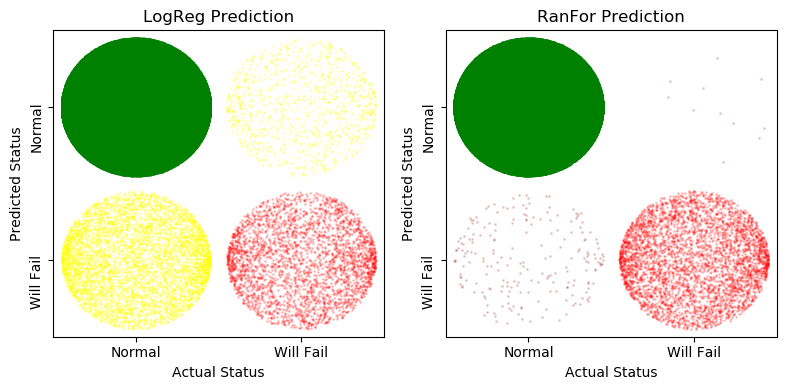

In [46]:
def con_mat_circles(true_values,predicted_values,cname='This_Con_Mat',
                   colors=['green','yellow','yellow','red']):
    df_con=pd.DataFrame(columns=['Actual','Predicted'])
    df_con['Actual']=true_values
    df_con['Predicted']=predicted_values
    
    
    
    legends=['\nNormal\n','False\nNegative','\nAction\nRequired\n','False\nPositive']
    i=0


    for a in range(2):
        for b in range (2):
            tmp=df_con.loc[(df_con.Actual==a)&(df_con.Predicted==b),:]
            x,y=get_con_mat_pts(tmp.Actual.values,tmp.Predicted.values)
            plot_group(x,y,color=colors[i],label=legends[i])
            i+=1
    plt.title(cname+' Prediction')
    return

plt.subplots(1,2,figsize=(8,4),dpi=100)
plt.subplot(1,2,1)
con_mat_circles(yt,ypred,cname='LogReg')
plt.subplot(1,2,2)

con_mat_circles(yt,ypred_rf,cname='RanFor',colors=['green','brown','brown','red'])
plt.tight_layout()
plt.savefig(plotdir+'both_mods.png')
plt.show()

## Evaluate economic impact of model

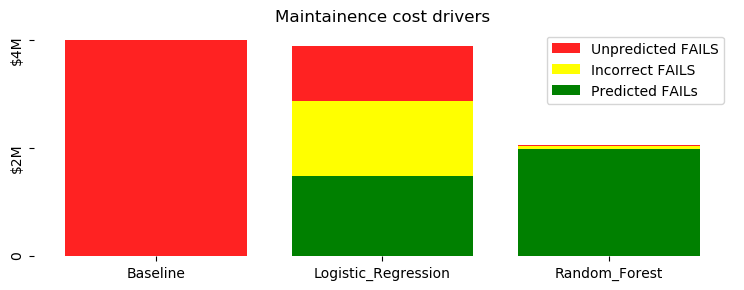

In [47]:
bsln_tp=0
bsln_fp=0
bsln_fn=log_reg_con_mat[1][1]+log_reg_con_mat[0][1]

lgrg_tp=log_reg_con_mat[1][1]
lgrg_fp=log_reg_con_mat[1][0]
lgrg_fn=log_reg_con_mat[0][1]

rnfr_tp=rnfr_con_mat[1][1]
rnfr_fp=rnfr_con_mat[1][0]
rnfr_fn=rnfr_con_mat[0][1]


tp=[bsln_tp,lgrg_tp,rnfr_tp]
fp=[bsln_fp,lgrg_fp,rnfr_fp]
fn=[bsln_fn,lgrg_fn,rnfr_fn]

con_df=pd.DataFrame(index=['tp','fp','fn'],columns=['1base','2log','3for'], data=[tp,fp,fn])

con_df.loc['tp',:]=con_df.loc['tp',:]*500
con_df.loc['fp',:]=con_df.loc['fp',:]*250
con_df.loc['fn',:]=con_df.loc['fn',:]*1000

all_three=con_df.sum()
second=con_df.loc['tp',:]+con_df.loc['fp',:]
third=con_df.loc['tp',:]

order=['Baseline','Logistic_Regression','Random_Forest']

plt.figure(figsize=(9,3),dpi=100)
plt.bar(con_df.columns,all_three,color='#ff2222',label='Unpredicted FAILS')
plt.bar(con_df.columns,second,color='yellow',label='Incorrect FAILS')
plt.bar(con_df.columns,third,color='green',label='Predicted FAILs')

plt.title('Maintainence cost drivers')
plt.xticks([0,1,2],order)
plt.yticks([0,con_df.sum()[0]/2,con_df.sum()[0]],['0','$2M','$4M'],rotation=90)
plt.legend(loc='upper right',)
plt.box(on=False)
plt.savefig(plotdir+'cost_drivers.png')
plt.show()

In [48]:
import pickle
pickle.dump(clf_grid,open(datadir+"clf_grid.p","wb"))
pickle.dump(rf_random,open(datadir+"rf_random.p","wb"))
print 'Done'

Done


In [49]:
df=pd.read_csv('C:\\Users\\bill_\\df_all_w_before_model.csv')
df.head(1)

,Unnamed: 0,machineID,volt,rotate,pressure,vibration,dt1,hour,dow,date_str,zipper,model,age,errorID,fails,error1,error2,error3,error4,error5,tot_err,tm_from_fail,run_num,tm_from_e1,run_num_e1,tm_from_e2,run_num_e2,tm_from_e3,run_num_e3,tm_from_e4,run_num_e4,tm_from_e5,run_num_e5,age_fail_low,age_fail_mean,age_fail_high,age_e1_low,age_e1_mean,age_e1_high,age_e2_low,age_e2_mean,age_e2_high,age_e3_low,age_e3_mean,age_e3_high,age_e4_low,age_e4_mean,age_e4_high,age_e5_low,age_e5_mean,age_e5_high,model_fail_low,model_fail_mean,model_fail_high,model_e1_low,model_e1_mean,model_e1_high,model_e2_low,model_e2_mean,model_e2_high,model_e3_low,model_e3_mean,model_e3_high,model_e4_low,model_e4_mean,model_e4_high,model_e5_low,model_e5_mean,model_e5_high,age_fail__Q1,age_fail__Q2,age_fail__Q3,age_fail__Q4,age_e1__Q1,age_e1__Q2,age_e1__Q3,age_e1__Q4,age_e2__Q1,age_e2__Q2,age_e2__Q3,age_e2__Q4,age_e3__Q1,age_e3__Q2,age_e3__Q3,age_e3__Q4,age_e4__Q1,age_e4__Q2,age_e4__Q3,age_e4__Q4,age_e5__Q1,age_e5__Q2,age_e5__Q3,age_e5__Q4,model_fail__Q1,model_fail__Q2,model_fail__Q3,model_fail__Q4,model_e1__Q1,model_e1__Q2,model_e1__Q3,model_e1__Q4,model_e2__Q1,model_e2__Q2,model_e2__Q3,model_e2__Q4,model_e3__Q1,model_e3__Q2,model_e3__Q3,model_e3__Q4,model_e4__Q1,model_e4__Q2,model_e4__Q3,model_e4__Q4,model_e5__Q1,model_e5__Q2,model_e5__Q3,model_e5__Q4,volt__roll3,volt__roll24,volt__3sdev,volt__24sdev,volt__24max,volt__24min,rotate__roll3,rotate__roll24,rotate__3sdev,rotate__24sdev,rotate__24max,rotate__24min,pressure__roll3,pressure__roll24,pressure__3sdev,pressure__24sdev,pressure__24max,pressure__24min,vibration__roll3,vibration__roll24,vibration__3sdev,vibration__24sdev,vibration__24max,vibration__24min,pre_low,pre_mn,pre_hgh,pre_std,rot_low,rot_mn,rot_hgh,rot_std,vib_low,vib_mn,vib_hgh,vib_std,vol_low,vol_mn,vol_hgh,vol_std,vol__Q1,vol__Q2,vol__Q3,vol__Q4,pre__Q1,pre__Q2,pre__Q3,pre__Q4,rot__Q1,rot__Q2,rot__Q3,rot__Q4,vib__Q1,vib__Q2,vib__Q3,vib__Q4
0,0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,6,Thursday,2015-1-1,"(1L, Timestamp('2015-01-01 06:00:00'))",model3,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,123.817478,847.741935,1571.666393,309.141261,1128.774194,1948.407127,350.798365,1175.725806,2000.653248,165.219371,1242.096774,2318.974177,152.896742,1460.387097,2767.877452,388.159904,1232.516129,2076.872354,100.843384,1241.295547,2381.747709,306.464195,1178.186235,2049.908275,374.95737,1182.230769,1989.504168,274.823445,1290.890688,2306.957931,571.674121,1846.939271,3122.204422,431.193729,1991.396761,3551.599793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,176.217853,176.217853,12.341544,14.762877,176.217853,176.217853,418.504078,418.504078,42.019344,49.66874,418.504078,418.504078,113.077935,113.077935,8.249437,9.957643,113.077935,113.077935,45.087686,45.087686,4.248164,5.042026,45.087686,45.087686,89.808436,100.667673,111.52691,10.859237,394.068,446.312874,498.557749,52.244874,35.044245,40.585863,46.127482,5.541618,155.518713,170.835978,186.153242,15.317264,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Feature Importance

Given the results above, it is fair to expect some questions on the important components of the model.  The following code uses the parameters derived for the random forest and selsects the most important features.

Interestingly, the run times between error codes mapped across model type and age of individual machines are about equally important to the sensor readings in the various lag functions that were derived.


No features with importance >= 0.08


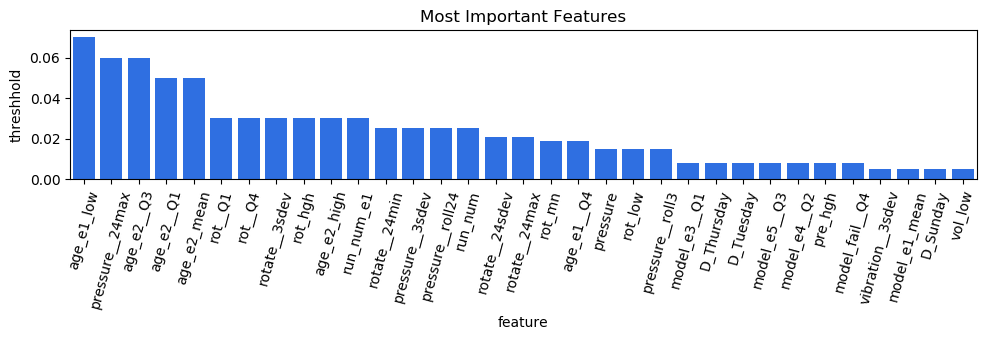

In [50]:
from sklearn.feature_selection import SelectFromModel

feature_labels=df_bal.columns.difference(['fails','f24'])

rf_clf=RandomForestClassifier( bootstrap=False, min_samples_leaf=4,n_estimators=200, 
                              max_features='auto', min_samples_split=5, max_depth=30, 
                              random_state=42)

rf_clf.fit(X_train, y_train)

thresholds=[0.08,0.07,0.06,0.05,0.030,0.025,0.021,0.01875,0.015,0.0125,0.0075,0.005,.00375,.0025,0.001]
all_feats=[]
all_thresh=[]
last=0

for t in thresholds:
    
    sfm = SelectFromModel(rf_clf, threshold=t)

    # Train the selector
    sfm.fit(X_train, y_train)
    tmp=[]
    # Print the names of the most important features
    if len(sfm.get_support(indices=True))>0:
        for feature_list_index in sfm.get_support(indices=True):
            all_feats.append(feature_labels[feature_list_index])
            all_thresh.append(t)
            tmp.append(feature_labels[feature_list_index])
        #print 'Threshold > {} yields {} features'.format(t,len(tmp)-last)
        last=len(tmp)
    else:
        print 'No features with importance >= {}'.format(t)

feats_df=pd.DataFrame()
feats_df['feature']=all_feats
feats_df['threshhold']=all_thresh

importance_df=feats_df.pivot_table(index='feature',\
        values='threshhold',aggfunc='max').sort_values('threshhold',ascending=False)
importance_df.reset_index(drop=False,inplace=True)

plt.figure(figsize=(10,3.5),dpi=100)
feat=importance_df.loc[importance_df.threshhold>=0.005,:].round(3).sort_values('threshhold',ascending=False)
sns.barplot(x=feat.feature,y=feat.threshhold,color="#1166ff",ci=None)
plt.title('Most Important Features')
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig(plotdir+'Important_Features.png')
plt.show()

In [51]:
please_stop()

NameError: name 'please_stop' is not defined

# Extras:

The following cells are not necessary to get to the conclusions, but were used to generate some graphics for the presentation.  May require some name changes to run, as they were done early in th eproblem and df names have changed.

In [ ]:

plt.subplots(2,1,figsize=(5,4),dpi=100)
model_45=df_all.loc[df.model=='model2',['machineID','tm_from_fail','run_num']]
bob=model_45.groupby(['machineID','run_num'])['tm_from_fail'].max()

bob_mean=bob.mean()
bob_high=bob_mean+bob.std()
bob_low=bob_mean-bob.std()
plt.subplot(2,1,1)
plt.plot([bob_low,bob_low],[0,72],color='w',lineStyle='--')
plt.plot([bob_mean,bob_mean],[0,72],color='w',lineStyle='--')
plt.plot([bob_high,bob_high],[0,72],color='w',lineStyle='--')
plt.xticks([2,400,1200,2500],['Q1','Q2','Q3','Q4'])
plt.title('Failure Run Time Groupings')
plt.hist(bob,bins=10)


model_45=df.loc[df.model=='model2',['machineID','volt__roll24','run_num']]
tom=model_45.groupby(['machineID','run_num'])['volt__roll24'].max()
tom_mean=tom.mean()
tom_high=tom_mean+tom.std()
tom_low=tom_mean-tom.std()

plt.subplot(2,1,2)
plt.plot([tom_low,tom_low],[0,50],color='w',lineStyle='--')
plt.plot([tom_mean,tom_mean],[0,50],color='w',lineStyle='--')
plt.plot([tom_high,tom_high],[0,50],color='w',lineStyle='--')
plt.xticks([173,(tom_low+tom_mean)/2.,(tom_high+tom_mean)/2.,(tom_high+tom.max())/2.],['Q1','Q2','Q3','Q4'])
plt.title('Temperature Groupings')
plt.hist(tom,bins=10)
plt.tight_layout()
plt.savefig(plotdir+'Qgroupings.png')
plt.show()

In [ ]:

bob=df.groupby(['age','machineID','run_num'])['tm_from_fail'].max()
bob=pd.DataFrame(bob)

age_m=bob.groupby('age')['tm_from_fail'].mean()
age_sdev=bob.groupby('age')['tm_from_fail'].std()
tom=pd.DataFrame()
tom['low']=age_m-age_sdev
tom['mean']=age_m
tom['high']=age_m+age_sdev

model='model4'
plt.figure(figsize=(12,2.5),dpi=100)
#al=bob.reset_index(drop=False)
#al=al.loc[df.model=='model2',:].head(25)
sns.boxplot(x='age',y='tm_from_fail',data=df,color='#1166ff')
plt.plot(tom.high,color='green', label='{} Mean+SDEV'.format(model))
plt.title('Run Lengths all Models')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(plotdir+'Outliers_by_age.png')
plt.show()

del age_m,age_sdev,al,tom,bob